In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

# Import geomap of the Netherlands
mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
mapdf = mapdf[mapdf["H2O"] == "NEE"]
mapdf.sort_values("GM_NAAM", inplace=True)
mapdf = mapdf.reset_index(drop=True)
print(mapdf.columns)

# Compute distances between all municipalities
mapdf['GEO_CENTROID'] = mapdf.centroid
centres = mapdf['GEO_CENTROID']
n_mun = mapdf.shape[0]

# dist_matrix = np.zeros(shape=(n_mun, n_mun))
# for i in range(0, n_mun):
#     dist_matrix[i] = centres.distance(centres[i])

# Compute mobility based gravity model, without distances
population = mapdf['AANT_INW']
mob_matrix = np.zeros(shape=(n_mun, n_mun))
for i in range(0, n_mun):
    for j in range(0, n_mun):
        if i != j:
            mob_matrix[i,j] = population[i] * population[j]

# Import original data to normalize to
df_mobmat_freq = pd.read_csv('Data/Mob_grav_freq.csv', delimiter=',')
mobmat_freq = df_mobmat_freq[df_mobmat_freq.columns[1:]].to_numpy()

df_mobmat_inc = pd.read_csv('Data/Mob_grav_inc.csv', delimiter=',')
mobmat_inc = df_mobmat_inc[df_mobmat_inc.columns[1:]].to_numpy()

# Normalize row sums to original data, so total amount traveled per municipality is the same.
mob_matrix_freq = np.zeros(shape=(n_mun, n_mun))
mob_matrix_inc = np.zeros(shape=(n_mun, n_mun))
for i in range(n_mun):
    diff_freq = np.nansum(mob_matrix[i]) / np.nansum(mobmat_freq[i])
    mob_matrix_freq[i] = mob_matrix[i] / diff_freq

    diff_inc  = np.nansum(mob_matrix[i]) / np.nansum(mobmat_inc[i])
    mob_matrix_inc[i] = mob_matrix[i] / diff_inc

# Save the new matrix
path = os.getcwd() + '/Data/'
np.save(path + 'Randomized_mob_grav_freq', mob_matrix_freq)
np.save(path + 'Randomized_mob_grav_inc', mob_matrix_inc)

Index(['GM_CODE', 'GM_NAAM', 'H2O', 'OAD', 'STED', 'BEV_DICHTH', 'AANT_INW',
       'AANT_MAN', 'AANT_VROUW', 'P_00_14_JR',
       ...
       'AV20PODIUM', 'AF_MUSEUM', 'AV5_MUSEUM', 'AV10MUSEUM', 'AV20MUSEUM',
       'JRSTATCODE', 'JAAR', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object', length=205)


In [9]:
import os


folder_to_clear = "D:/University/thesis/covid-gravity-model/Data/Model_V1/Data/High/Seed_5"

for demo in range(0, 11):
    path = folder_to_clear + '/Runs_ref_3_3_5_' + str(demo)
    for run in range(0, 10):
        os.remove(path + '/Contacts_per_agent_' + str(run) + '.npy')


In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib
import pandas as pd
import numpy as np
import os

ppl_per_agent = 100

path_gem_names = os.getcwd() + '/Data/Gem_alfabetisch_2018.csv'

DF_Gem = pd.read_csv(path_gem_names, delimiter=';', encoding='latin-1')
UniLocs = np.unique(DF_Gem.Gemeentenaam)
UniIDs = [list(DF_Gem.GemeentecodeGM[DF_Gem.Gemeentenaam == i])[0] for i in UniLocs]

path_demo = os.getcwd() + '/Data/DemographicMatrix.csv'

DF_Demo = pd.read_csv(path_demo, delimiter=',')
DemoIDs = np.array(DF_Demo['Unnamed: 0'])
DemoMat_unsorted = np.array(DF_Demo[DF_Demo.keys()[1:]])
DemoMat_sorted = []
for ID in UniIDs:
    DemoMat_sorted.append(DemoMat_unsorted[DemoIDs == int(ID.lstrip('GM'))])
DemoMat = (np.array(DemoMat_sorted)/ppl_per_agent).astype(int)[:, 0]

DemoFractionsMat = np.zeros(shape=DemoMat.shape)
for i in range(0, DemoMat.shape[0]):
    DemoFractionsMat[i] = DemoMat[i] / np.sum(DemoMat[i])



# Useful functions
def create_spatial_plot(data_per_municipality, title, legend_label):
    '''
    Plot map with data per municipality
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_val = np.max(data_per_municipality)

    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    fig.suptitle(title)
    ax.axis('off')

    mapdf.insert(0, 'DATA', data_per_municipality)

    mapdf.plot(ax=ax, column="DATA", 
               legend=True, legend_kwds={"label": legend_label, "orientation": "horizontal"})

    plt.plot()



def create_spatial_4plots(data_per_municipality, title, legend_label):
    '''
    Plot 4 maps, evenly spread out over time
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    max_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 4, figsize=(20, 8))
    fig.suptitle(title)

    mapdf.insert(0, 'DATA_QUARTER', data_per_municipality[int(max_time/4)])
    mapdf.insert(0, 'DATA_HALF', data_per_municipality[int(max_time/2)])
    mapdf.insert(0, 'DATA_3QUARTER', data_per_municipality[int(max_time*3/4)])
    mapdf.insert(0, 'DATA_MAXTIME', data_per_municipality[max_time-1])

    mapdf.plot(ax=axs[0], column="DATA_QUARTER", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[1], column="DATA_HALF", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[2], column="DATA_3QUARTER", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[3], column="DATA_MAXTIME", norm=matplotlib.colors.LogNorm(1,max_val))


    axs[0].set_title('t=' + str(int(max_time/4)))
    axs[1].set_title('t=' + str(int(max_time/2)))
    axs[2].set_title('t=' + str(int(max_time*3/4)))
    axs[3].set_title('t=' + str(int(max_time-1)))

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    axs[3].axis('off')

    mappable = cm.ScalarMappable(
        norm=mcolors.Normalize(1, max_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


# DAILY PLOT FOR 1 WEEK

def create_spatial_7plots(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot a daily map for 1 week
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = day + 1
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), norm=matplotlib.colors.LogNorm(1, max_legend_val))
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    mappable = cm.ScalarMappable(
        norm=matplotlib.colors.LogNorm(1, max_legend_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


def create_spatial_7plots3(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot 7 maps, spaced 3 days apart
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = (day + 1) * 3
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), norm=matplotlib.colors.LogNorm(1, max_legend_val))
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    mappable = cm.ScalarMappable(
        norm=matplotlib.colors.LogNorm(1, max_legend_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


def combine_runs_avg(all_run_data):
    merged_data = np.zeros(shape= all_run_data[0].shape)
    for i in range (0, len(all_run_data)):
        merged_data = merged_data + all_run_data[i]
    merged_data = (merged_data / len(all_run_data)) + 0.000001
    return merged_data

def combine_demos_weighted(municipality_id, demo_run_data):
    fracs = DemoFractionsMat[municipality_id]
    merged_data = np.zeros(shape= demo_run_data[0].shape)
    for i in range (0, len(demo_run_data)):
        weighted = fracs[i] * demo_run_data[i]
        merged_data = merged_data + weighted
    merged_data = merged_data + 0.000001
    return merged_data


C:\Users\Larsk\AppData\Local\Temp\ipykernel_12084\2475962256.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Larsk\AppData\Local\Temp\ipykernel_12084\2475962256.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Larsk\AppData\Local\Temp\ipykernel_12084\2475962256.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Larsk\AppData\Local\Temp\ipykernel_12084\2475962256.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Larsk\AppData\Local\Temp\ipykernel_12084\2475962256.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.

Day 3: 111.01588787601236
Day 6: 233.44783061657608
Day 9: 557.7686758068317
Day 12: 1049.5289589767654
Day 15: 1883.5314733535606
Day 18: 3374.9038254309553
Day 21: 5746.566898621273


C:\Users\Larsk\AppData\Local\Temp\ipykernel_12084\2475962256.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


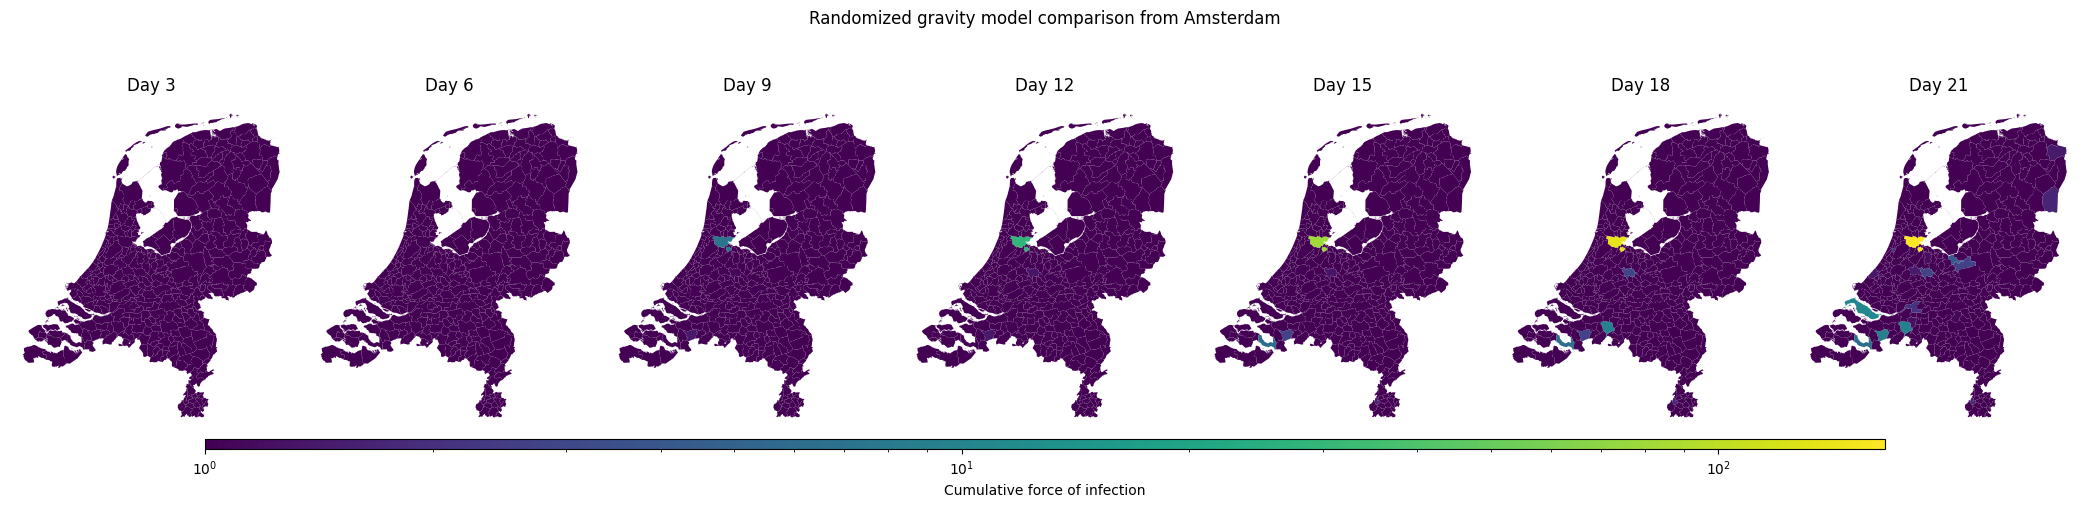

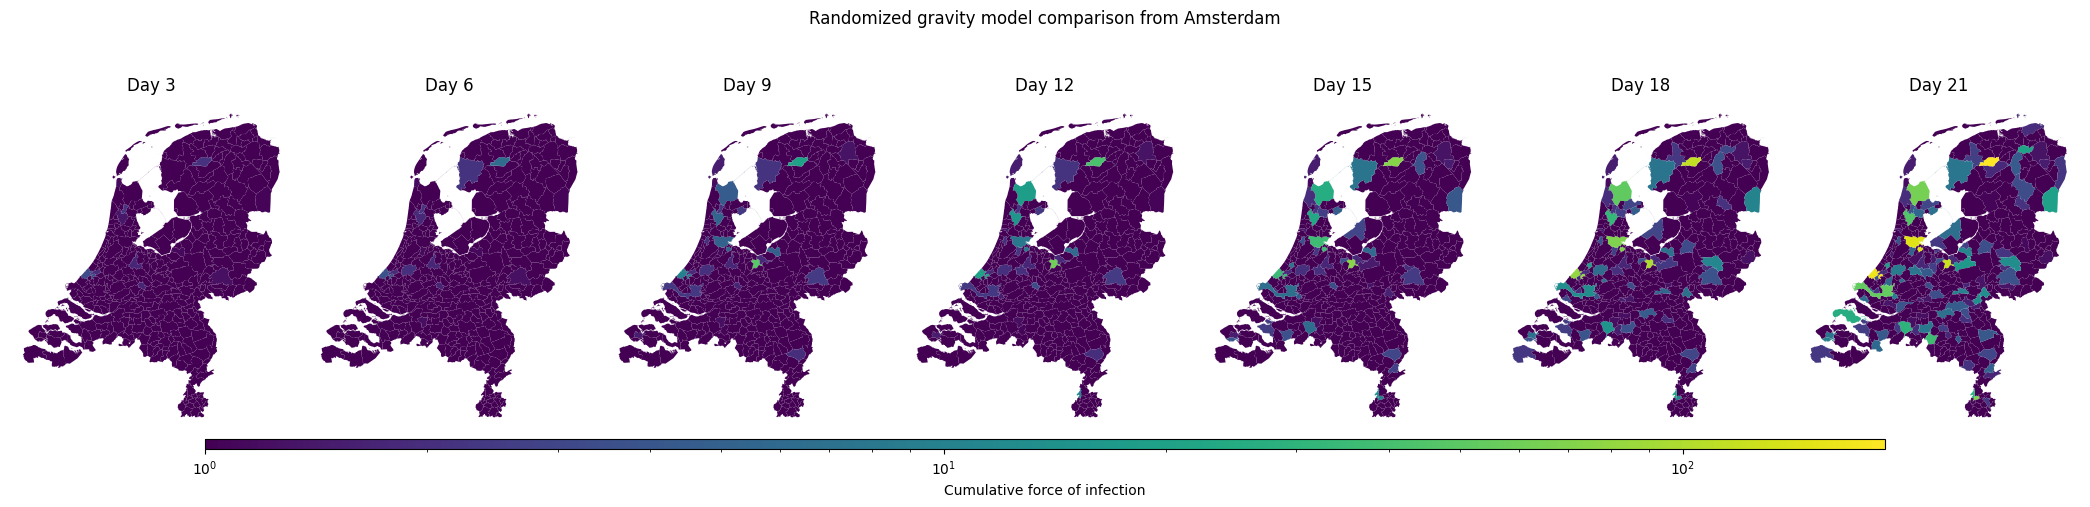

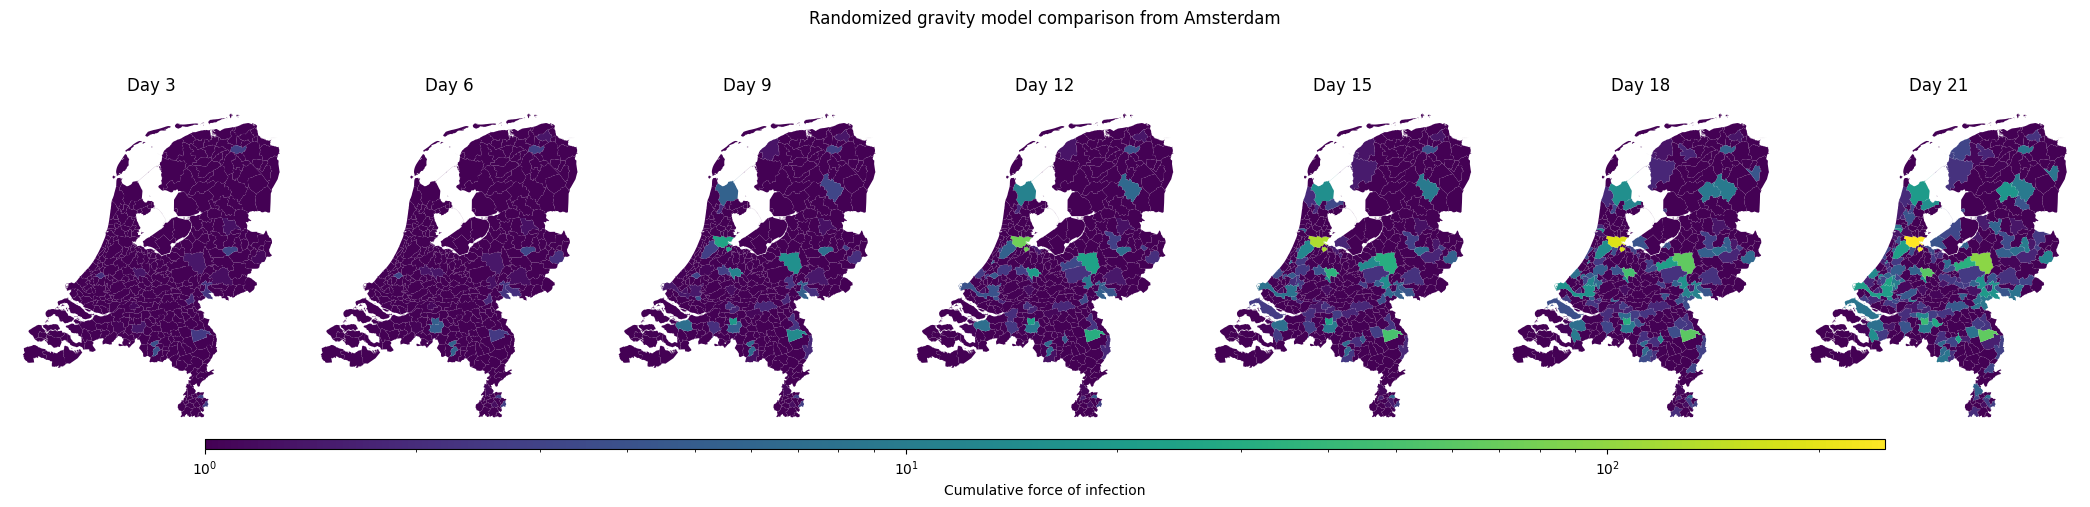

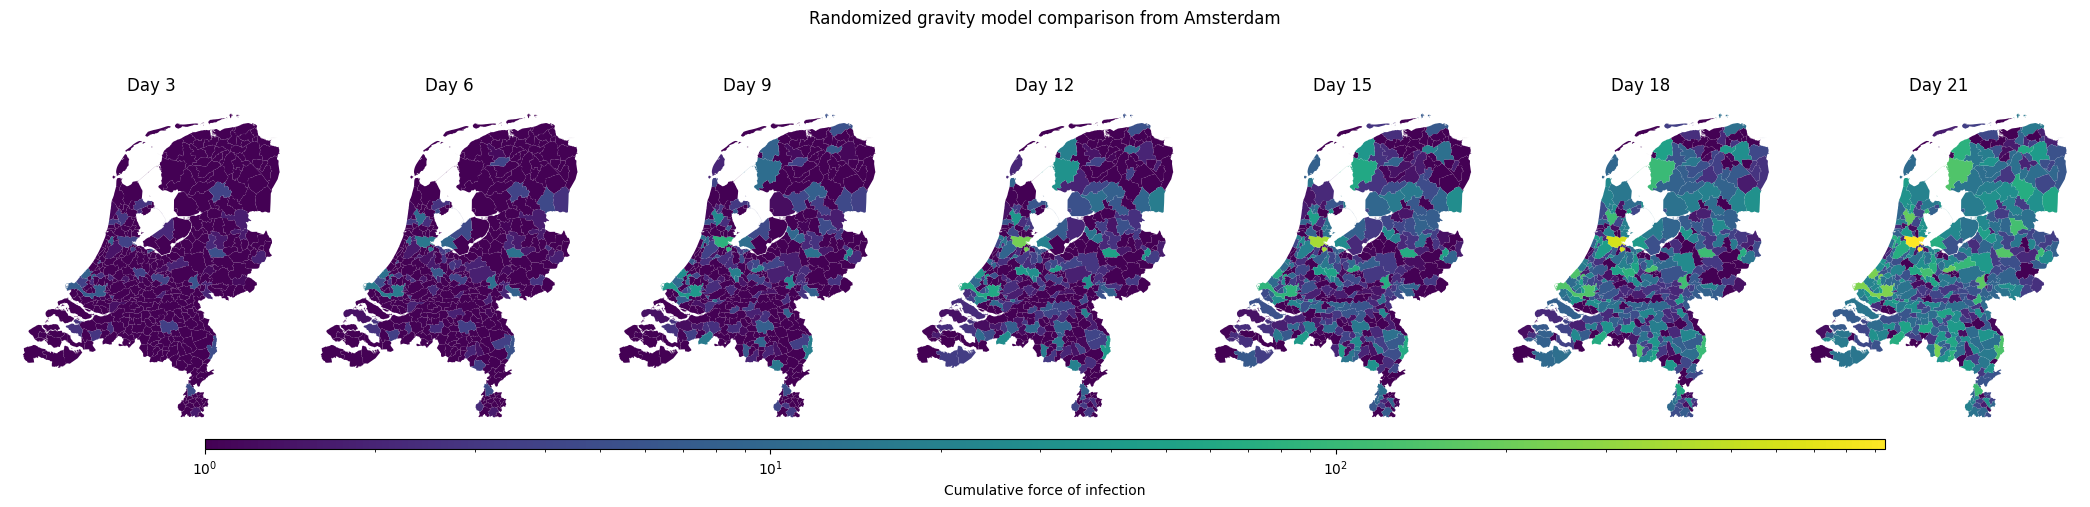

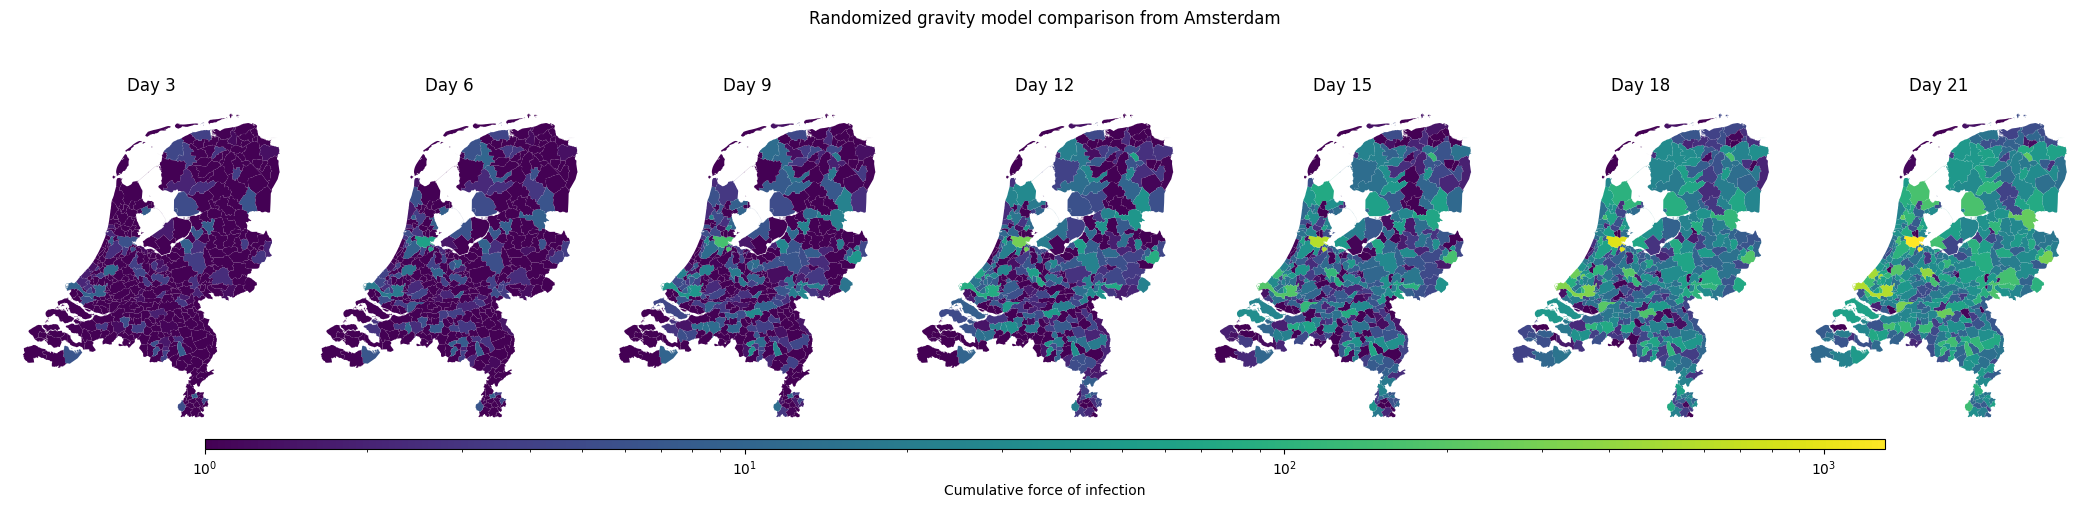

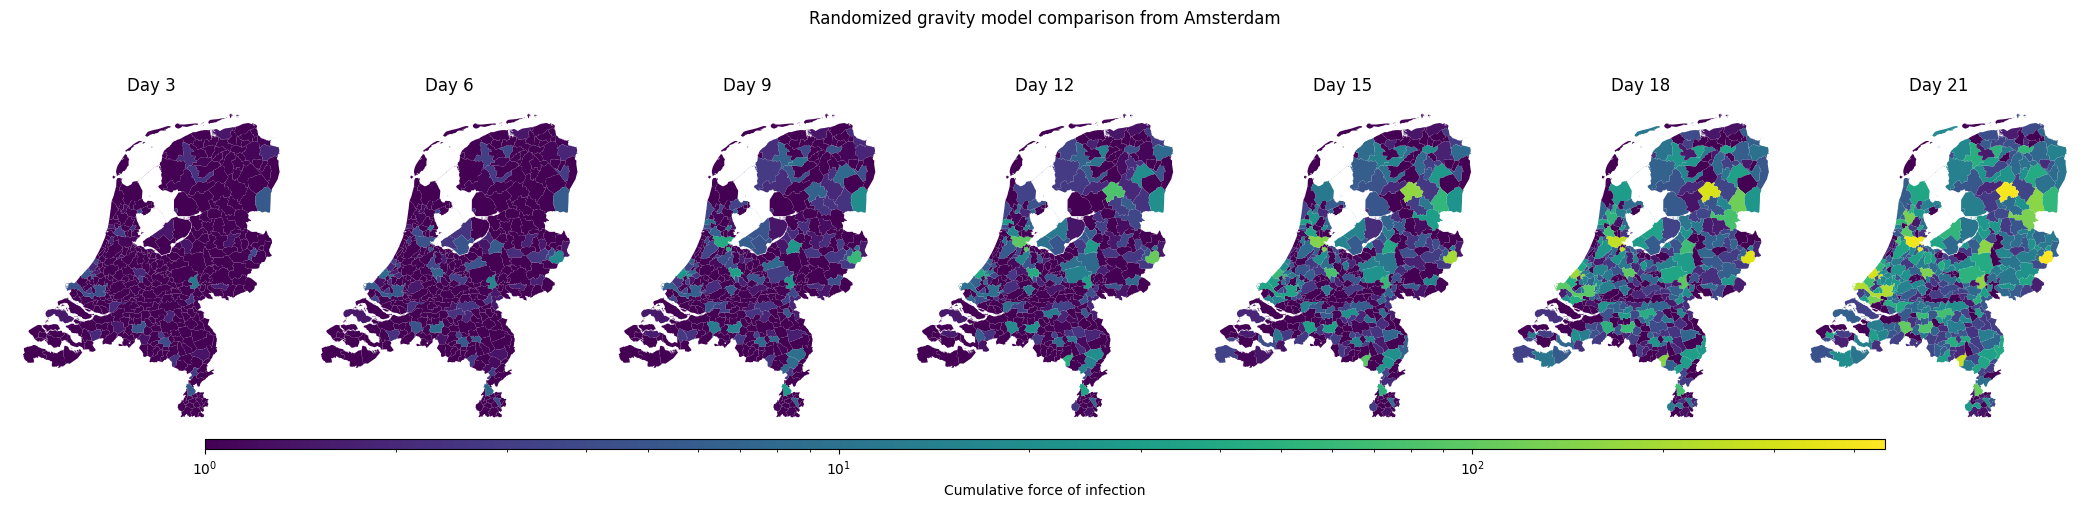

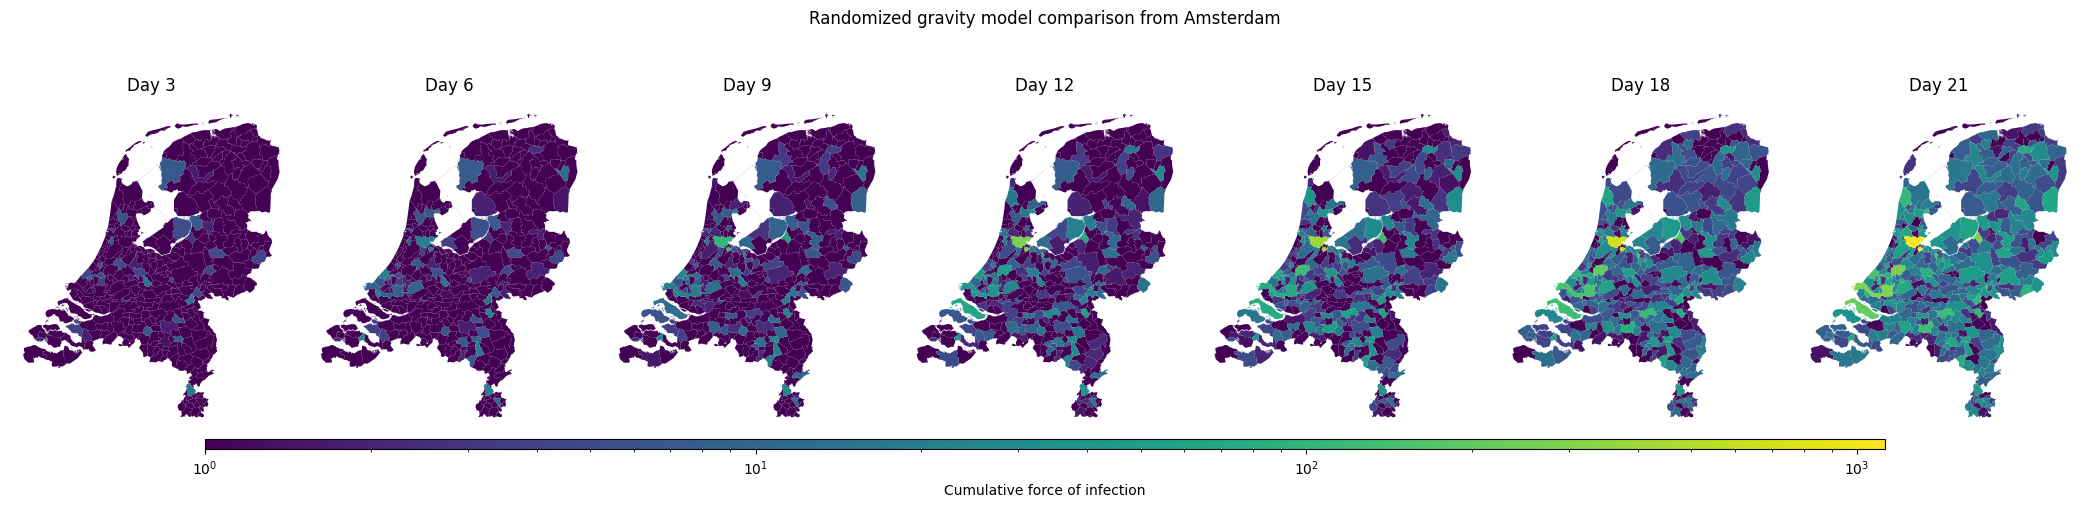

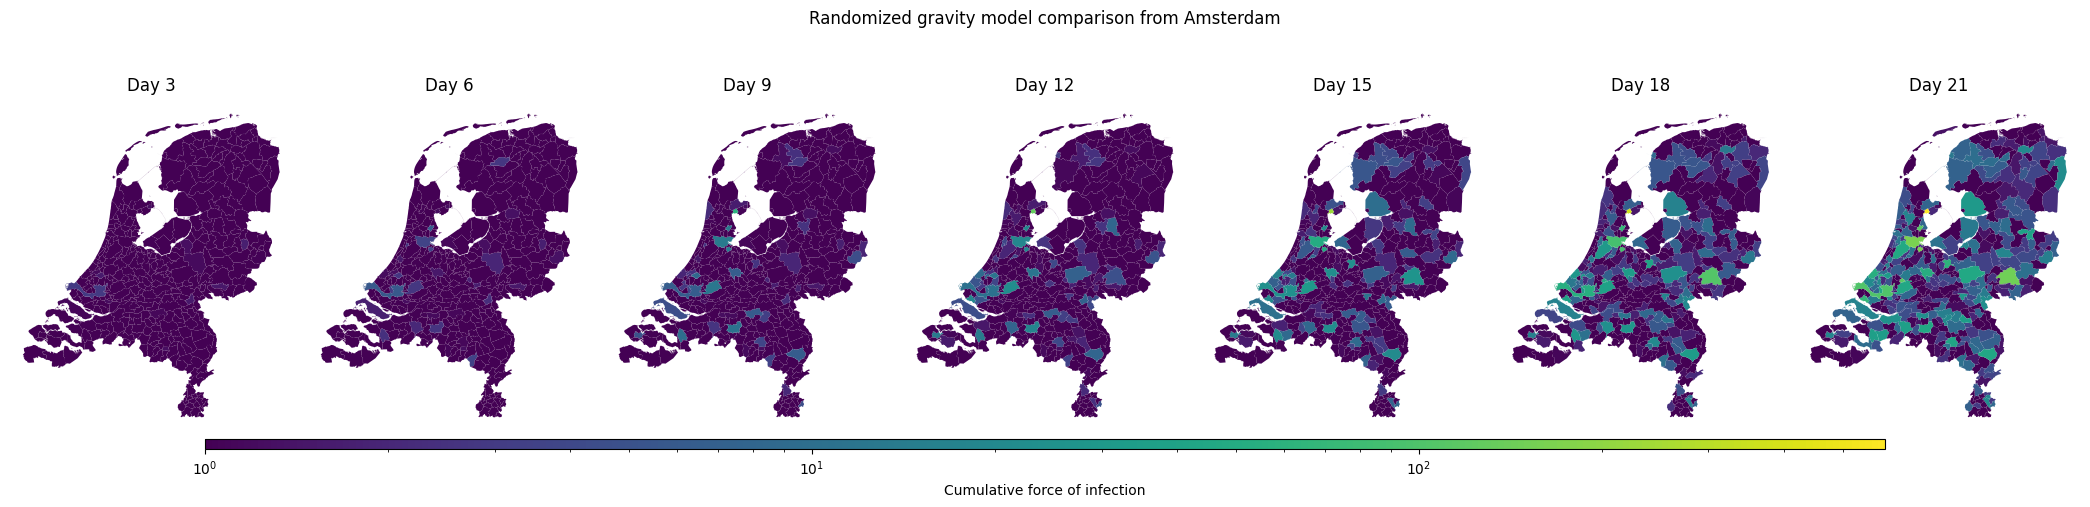

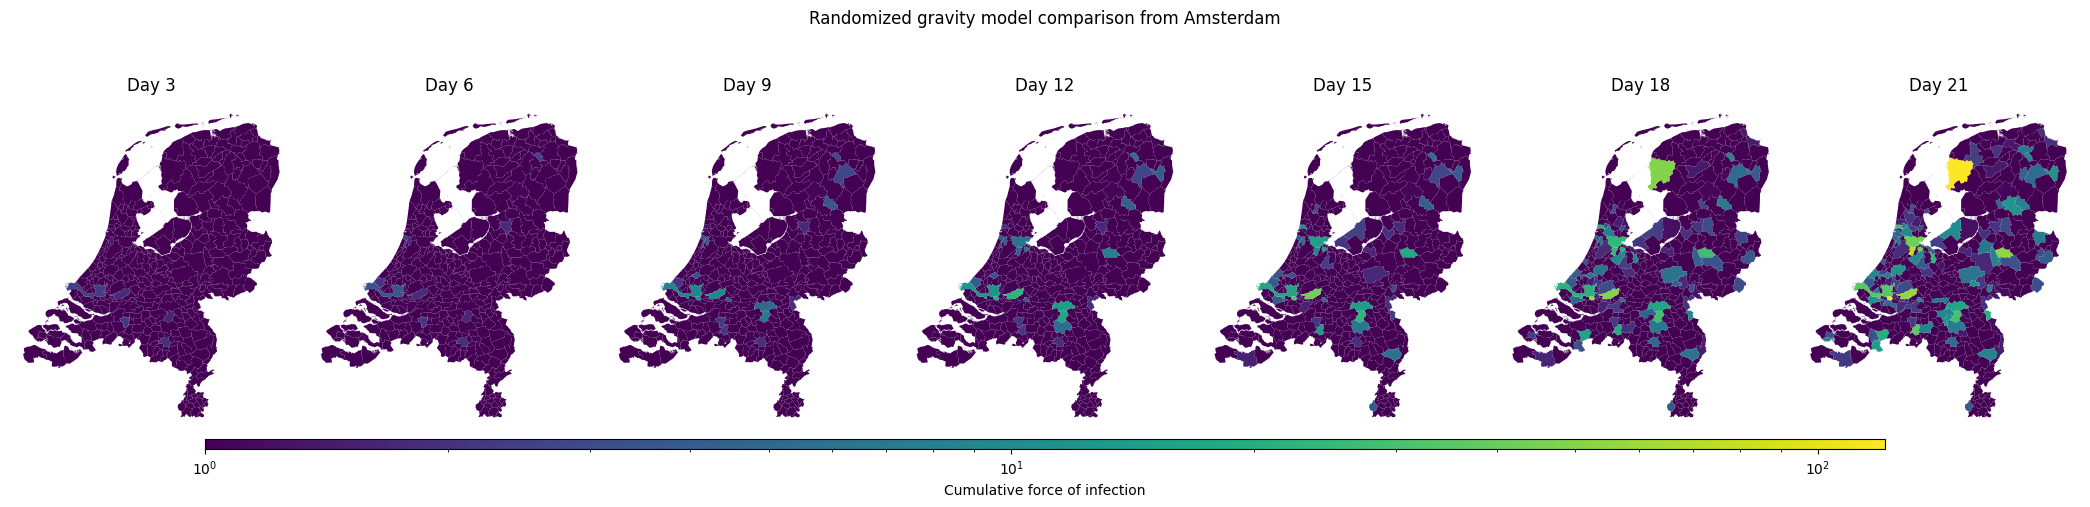

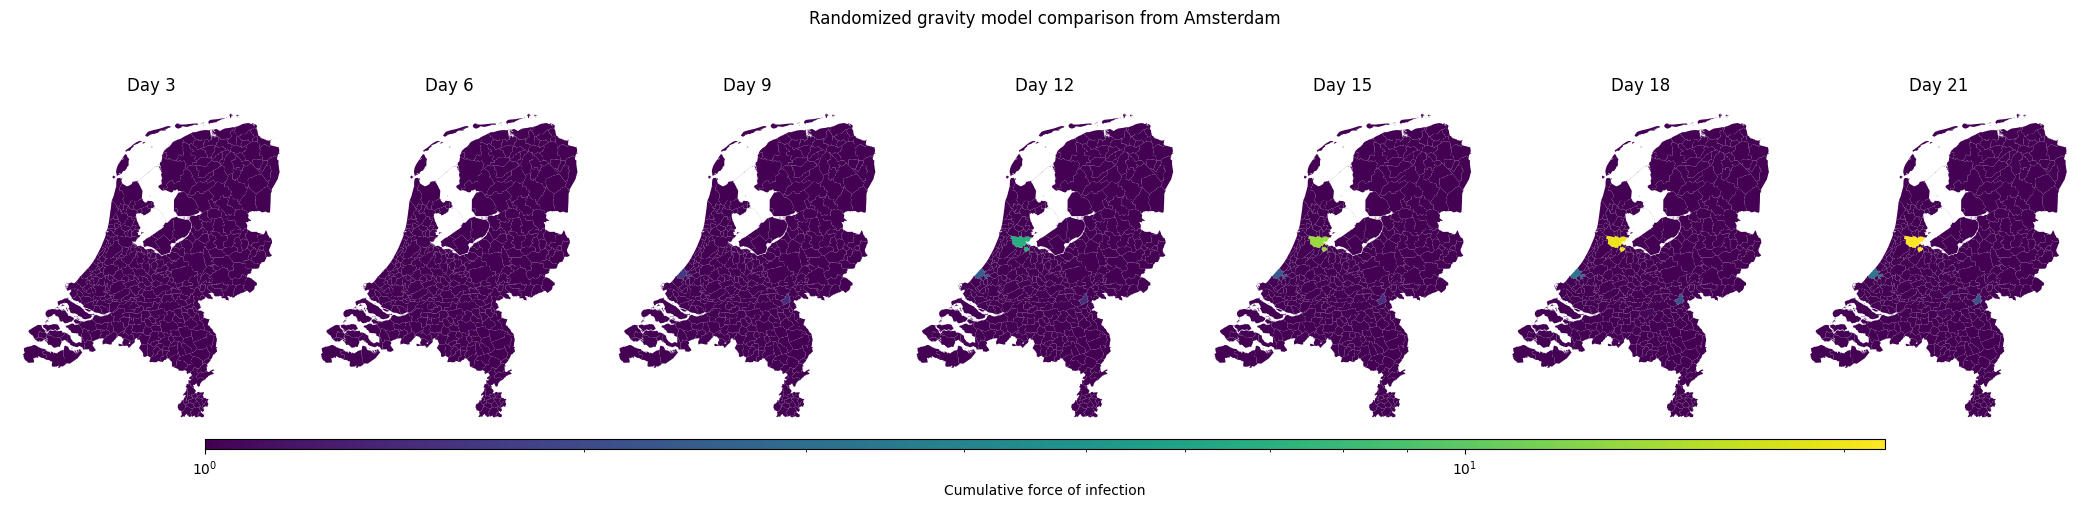

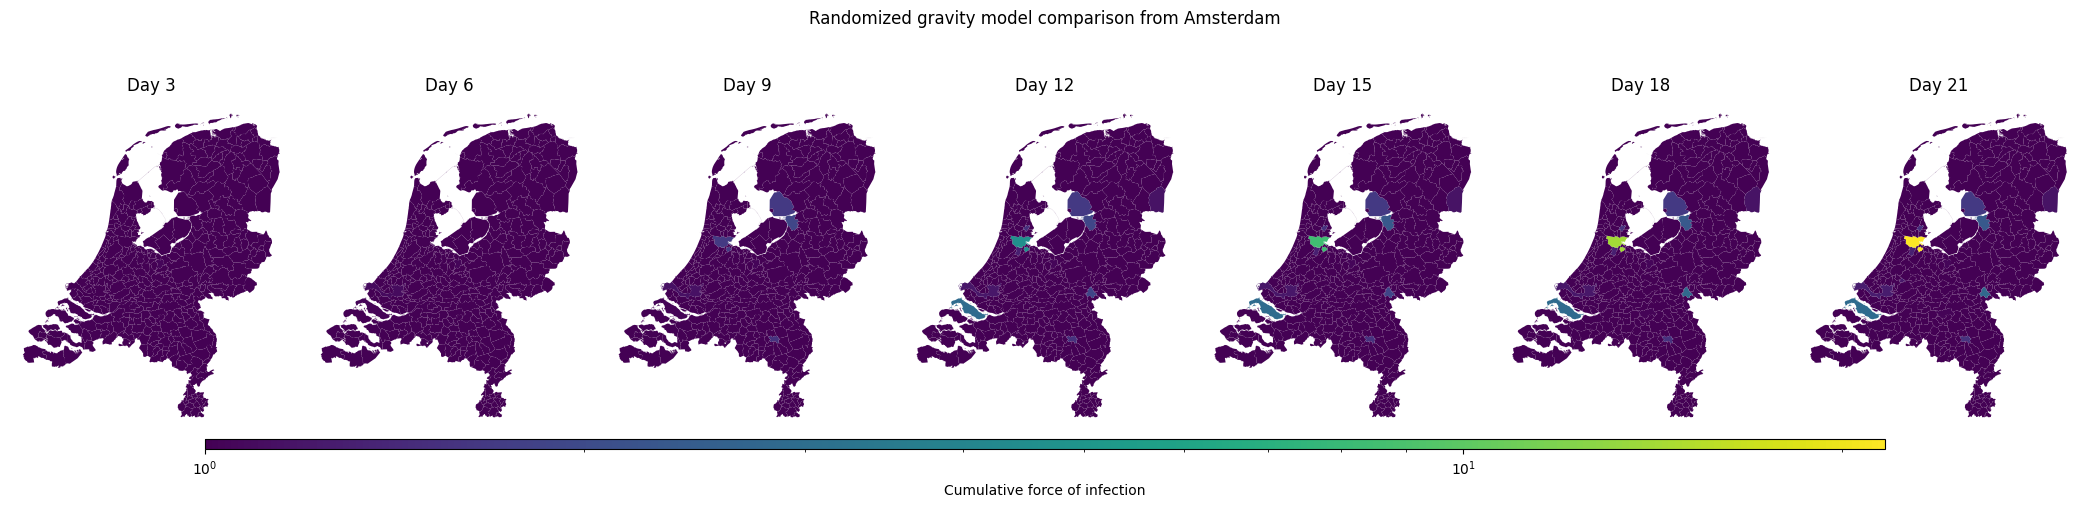

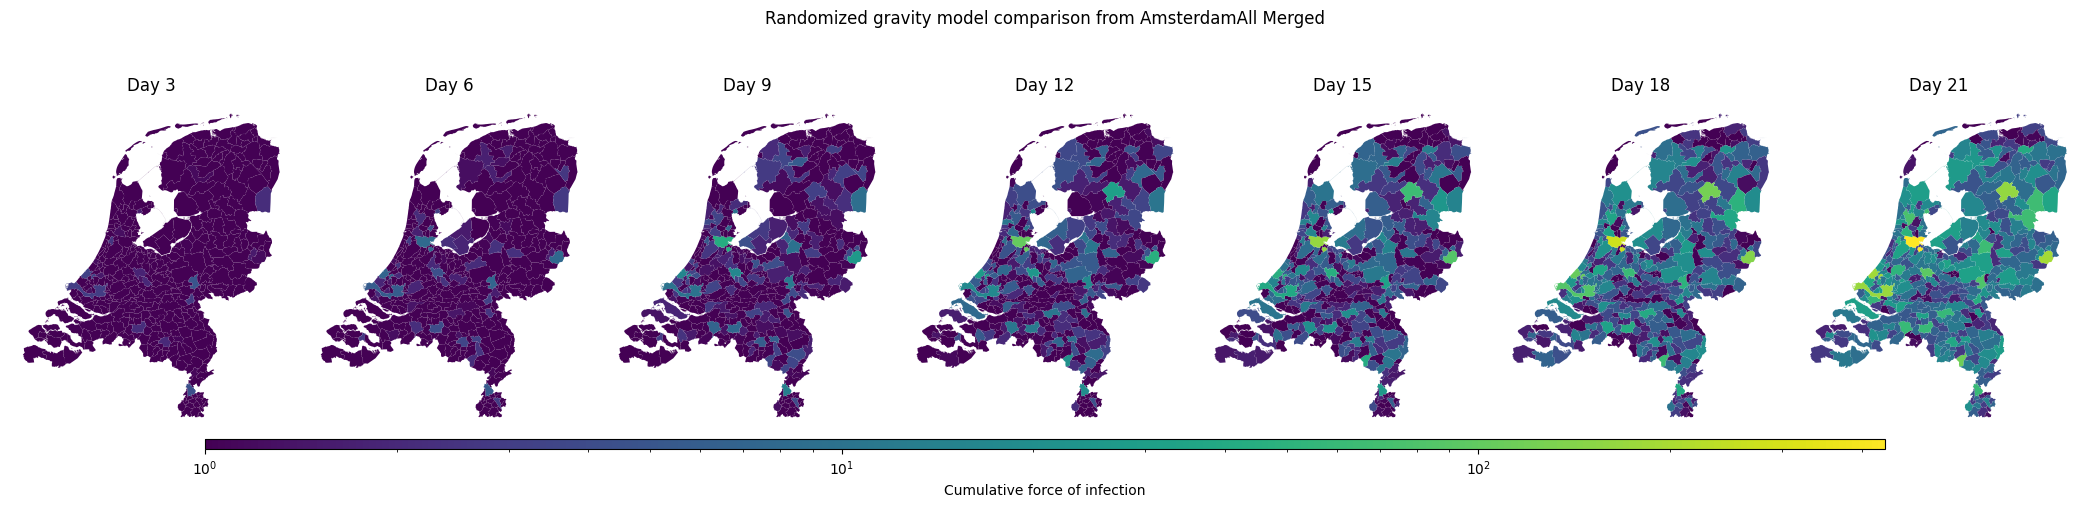

In [12]:
# CUMULATIVE INFECTIOIN PRESSURE OF WHOLE SEIR MODEL
# Runs: 0 = Amsterdam, 1 = Heerde, 2 = Eindhoven, 3 = Groningen

import numpy as np
import os

demo_group_labels = [
    'Pre-school children',
    'Primary school children',
    'Secondary school children',
    'Students',
    'Non-studying adolescents',
    'Middle-age working',
    'Middle-age unemployed',
    'Higher-age working',
    'Higher-age unemployed',
    'Elderly',
    'Eldest'
]

groundzero = np.where(UniLocs == 'Amsterdam')[0][0]

path_ref = os.getcwd() + '/Data/Model_V1/Data/High/Seed_8'
path_rnd = os.getcwd() + '/Data/Model_V1/Data/High/Seed_11'

title = 'Randomized gravity model comparison from Amsterdam'
all_demo_data = []
for demo in range(0, 11):
    #avg rnd model runs
    rnd_data = []
    for run in range(0, 3):
        foi_data_per_municipality = np.load(path_rnd + '/Runs_ref_4.6_100_5_risk17_' + str(demo) + '/Infection_Pressure_' + str(run) + '.npy')
        rnd_data.append(foi_data_per_municipality)
    avg_rnd_data_per_municipality = combine_runs_avg(rnd_data)

    # # avg ref model runs
    # ref_data = []
    # for run in range(0, 20):
    #     foi_data_per_municipality = np.load(path_ref + '/Runs_ref_4.6_100_5_' + str(demo) + '/Infection_Pressure_' + str(run) + '.npy')
    #     ref_data.append(foi_data_per_municipality)
    # avg_ref_data_per_municipality = combine_runs_avg(ref_data)

    # print(avg_ref_data_per_municipality/avg_rnd_data_per_municipality)

    create_spatial_7plots3(avg_rnd_data_per_municipality, None, title, 'Cumulative force of infection')


    all_demo_data.append(avg_rnd_data_per_municipality)
    #create_spatial_7plots3(merged_foi_data_per_municipality, None, title + demo_group_labels[demo], 'Cumulative force of infection')

merged_all_data = combine_demos_weighted(groundzero, all_demo_data)

create_spatial_7plots3(merged_all_data, None, title + 'All Merged', 'Cumulative force of infection', True)
